### notebook pour implementer l'analyse de fourier pour créer de nouvelles variables explicatives

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime

from numpy.fft import fft 
from numpy import pi, cos, sin 

from scipy.signal import find_peaks

from sklearn.linear_model import LinearRegression

In [2]:
#type pour chaque dataframe

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [3]:
#parametres de base pour le controle des jours à traiter

h = 28 
max_lags = 57 # nombre de jours max qu'on va regarder dans le passé
tr_last = 1913 # dernier jour à prédire dans la compet
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [6]:
def create_df(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("../../data/sell_prices.csv", dtype = PRICE_DTYPES)
    
    # one hot encoding pour toutes les variables catégorielles
    # ex : sunday = 0 etc...
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("../../data/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    
    # traiter les données depuis 5 ans en arrière serait trop long 
    # on décide donc de choisir un jour à partir duquel on va commencer à traiter les données
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    
    # on fait une liste des colonnes (elles ont des noms de type d_1300 on les selectionnes grace à ca)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    
    dtype = {numcol:"float32" for numcol in numcols}
    dtype.update({col: "category" for col in catcols if col != "id"})
    
    df = pd.read_csv("../../data/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    # one hot encoding sur la df de train
    for col in catcols:
        if col != "id":
            df[col] = df[col].cat.codes.astype("int16")
            df[col] -= df[col].min()
    
    # passage d'un format wide à un format long avec les jours et le nombre de sales pour la conversion
    df = pd.melt(df,
                  id_vars = catcols,
                  value_vars = [col for col in df.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    # merge de toutes les df
    df = df.merge(cal, on= "d", copy = False)
    df = df.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return df

In [7]:
FIRST_DAY = 1548 # si 0 souvent crash à cause de la mémoire

df = create_df(is_train=True, first_day= FIRST_DAY)
df.shape

(11126888, 22)

In [8]:
df.to_csv('df_merge_all.csv')

In [7]:
df[df['cat_id'] == 1]

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
564,HOUSEHOLD_1_001_CA_1_validation,565,2,0,1,0,d_1547,0.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,5.97
565,HOUSEHOLD_1_002_CA_1_validation,566,2,0,1,0,d_1547,0.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,5.97
566,HOUSEHOLD_1_003_CA_1_validation,567,2,0,1,0,d_1547,2.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,8.97
567,HOUSEHOLD_1_004_CA_1_validation,568,2,0,1,0,d_1547,0.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,2.36
568,HOUSEHOLD_1_005_CA_1_validation,569,2,0,1,0,d_1547,1.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,9.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11154072,HOUSEHOLD_2_514_WI_3_validation,2045,3,9,1,2,d_1913,0.0,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,2.50
11154073,HOUSEHOLD_2_515_WI_3_validation,2046,3,9,1,2,d_1912,1.0,2016-04-23,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,2.00
11154074,HOUSEHOLD_2_515_WI_3_validation,2046,3,9,1,2,d_1913,0.0,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,2.00
11154075,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.00


In [2]:
df_sy = pd.read_csv("../../data/sales_train_validation.csv")

df4=df_sy.groupby(['cat_id','store_id','state_id']).sum()
df4=df4.reset_index()
#df4=df4.rename(columns={'cat_id': 'id'})
#df4["id"] = [f"{lev}" for lev in df4['id'].values]
#df4['id'] = [f"{}" for lvl df4['store_id'].values]
new_col = df4['cat_id']+'_'+df4['store_id']
df4=df4.drop(columns=['cat_id','store_id','state_id'])
df4.insert(loc=0, column='id', value=new_col)
df4

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_CA_1,3239,3137,2008,2258,2032,2407,2693,3962,3418,...,2706,3481,4004,2886,2488,2490,2533,2960,3655,4053
1,FOODS_CA_2,2193,1921,1289,1540,1278,1494,1785,2385,1827,...,2891,3423,3729,2625,2410,2506,2261,2871,3760,4012
2,FOODS_CA_3,3446,3535,2701,3064,2761,3340,3455,4068,4324,...,3471,4307,5127,3827,3468,3286,3056,3409,4459,4698
3,FOODS_CA_4,1223,1269,946,1002,1107,1015,1072,1455,1408,...,1664,1883,1995,1879,1722,1581,1629,1751,1971,2043
4,FOODS_TX_1,1781,1903,1377,1643,1329,2091,1247,2008,2061,...,2049,2412,2629,2434,2113,1834,1777,1922,2319,2491
5,FOODS_TX_2,2788,2870,2082,2180,1890,2696,1963,2890,2750,...,2549,2795,3221,2268,2440,2196,2239,2547,2930,2853
6,FOODS_TX_3,2284,2257,1665,1647,1383,2280,1461,2157,2109,...,2396,2737,2867,2132,2513,2212,2151,2370,2600,2421
7,FOODS_WI_1,1581,1327,977,935,2,1278,1671,2016,1086,...,2700,3195,3501,2282,2135,2290,2285,2790,3242,3317
8,FOODS_WI_2,1615,1433,1586,2013,967,1709,1668,2064,1786,...,4836,4175,4157,3206,3282,3005,3078,3419,3751,3659
9,FOODS_WI_3,3028,3106,2543,2596,1854,3783,3475,4746,4093,...,3420,3599,3267,2612,2377,2232,2308,2665,3240,3107


In [109]:
for index, row in df4.iterrows():
    
    df_row = pd.DataFrame(row)
    
    df_row = df_row.T
    
    df_row = pd.melt(df_row,id_vars = 'id',
                  value_vars = [col for col in df_row.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    df_row['sales'] = df_row['sales'].astype('int32')
    
    df_row_1547 = df_row.iloc[1547:]
    
    x = df_row_1547['sales']
    M = len(x)
    xf = fft(x,M)
    f = np.arange(M)/M
    
    peaks = find_peaks(np.abs(xf), height=200, distance=30)
    
    ff1 = peaks[0][0] / M
    ff2 = peaks[0][1] / M
    ff3 = peaks[0][2]  / M
    ff4 = peaks[0][3]  / M
    
    reg = LinearRegression()
    
    t = np.arange(1547,1913)
    x1c = cos(2*pi*ff1*t )
    x1s = sin(2*pi*ff1*t )

    x2c = cos(2*pi*ff2*t )
    x2s = sin(2*pi*ff2*t )

    x3c = cos(2*pi*ff3*t )
    x3s = sin(2*pi*ff3*t )

    x4c = cos(2*pi*ff4*t )
    x4s = sin(2*pi*ff4*t )

    X = pd.DataFrame(data = {"t":t, "x1c":x1c, "x1s":x1s, "x2c":x2c, "x2s":x2s, "x3c":x3c, "x3s":x3s,
                             "x4c":x4c, "x4s": x4s})
    
    
    reg.fit(X,x)
    xx = reg.predict(X)
    
    df_xx = pd.DataFrame(xx)
    df_xx = df_xx.set_index(x.index)
    
    df_xx.to_csv('fourier_{}.csv'.format(row['id']))
    

In [7]:
df_t = df_sy[df_sy['id'] == 'FOODS_1_001_CA_1_validation']
df_t

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,...,0,2,0,4,1,1,0,1,1,0


In [5]:
df4 = df4.iloc[[0]]
df4

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_CA_1,3239,3137,2008,2258,2032,2407,2693,3962,3418,...,2706,3481,4004,2886,2488,2490,2533,2960,3655,4053


In [8]:
df_t = pd.melt(df_t,id_vars = 'id',
                  value_vars = [col for col in df_t.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

df_t

,id,d,sales
0,FOODS_1_001_CA_1_validation,d_1,3
1,FOODS_1_001_CA_1_validation,d_2,0
2,FOODS_1_001_CA_1_validation,d_3,0
3,FOODS_1_001_CA_1_validation,d_4,1
4,FOODS_1_001_CA_1_validation,d_5,4
...,...,...,...
1908,FOODS_1_001_CA_1_validation,d_1909,1
1909,FOODS_1_001_CA_1_validation,d_1910,0
1910,FOODS_1_001_CA_1_validation,d_1911,1
1911,FOODS_1_001_CA_1_validation,d_1912,1


In [9]:
df4_1547 = df_t.iloc[1547:]
df4_1547

,id,d,sales
1547,FOODS_1_001_CA_1_validation,d_1548,4
1548,FOODS_1_001_CA_1_validation,d_1549,0
1549,FOODS_1_001_CA_1_validation,d_1550,1
1550,FOODS_1_001_CA_1_validation,d_1551,0
1551,FOODS_1_001_CA_1_validation,d_1552,0
...,...,...,...
1908,FOODS_1_001_CA_1_validation,d_1909,1
1909,FOODS_1_001_CA_1_validation,d_1910,0
1910,FOODS_1_001_CA_1_validation,d_1911,1
1911,FOODS_1_001_CA_1_validation,d_1912,1


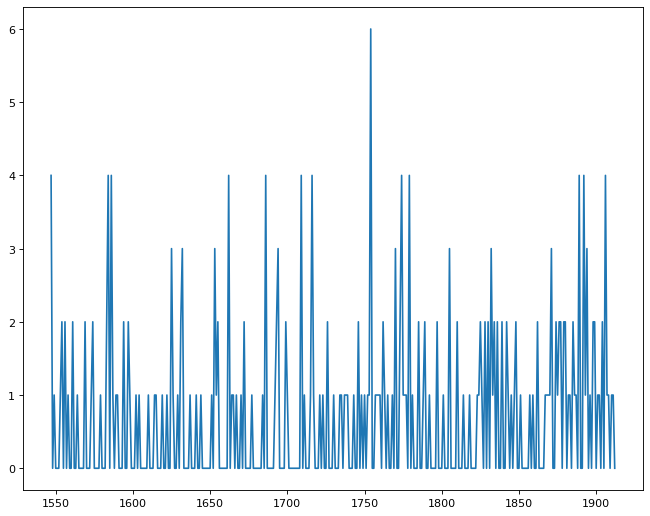

In [10]:
# affichage de l'année

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot('sales', data = df4_1547)


(0.0, 60.0, 0.0, 1000.0)

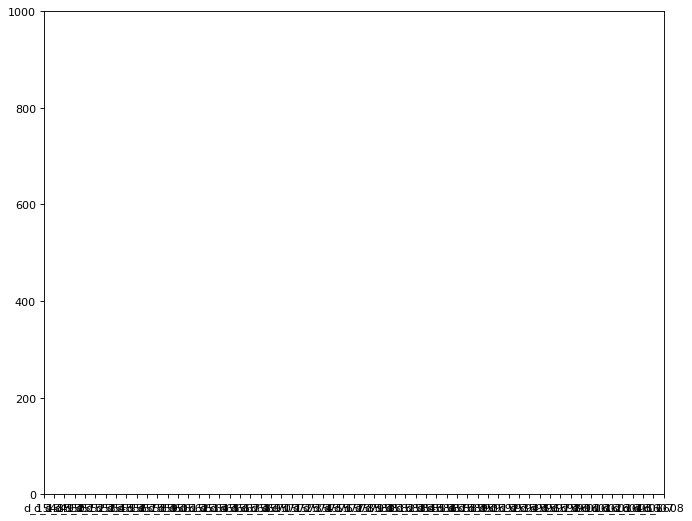

In [9]:
#zoom sur 2 mois
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot('d','sales', data = df4_1547)
plt.axis([0, 60, 0, 1000])

In [11]:
df4_1547['sales'].shape[0]

366

In [12]:
x = df4_1547['sales']
M = len(x)
#M = 182
xf = fft(x,M)
f = np.arange(M)/M
f

array([0.        , 0.00273224, 0.00546448, 0.00819672, 0.01092896,
       0.0136612 , 0.01639344, 0.01912568, 0.02185792, 0.02459016,
       0.0273224 , 0.03005464, 0.03278689, 0.03551913, 0.03825137,
       0.04098361, 0.04371585, 0.04644809, 0.04918033, 0.05191257,
       0.05464481, 0.05737705, 0.06010929, 0.06284153, 0.06557377,
       0.06830601, 0.07103825, 0.07377049, 0.07650273, 0.07923497,
       0.08196721, 0.08469945, 0.08743169, 0.09016393, 0.09289617,
       0.09562842, 0.09836066, 0.1010929 , 0.10382514, 0.10655738,
       0.10928962, 0.11202186, 0.1147541 , 0.11748634, 0.12021858,
       0.12295082, 0.12568306, 0.1284153 , 0.13114754, 0.13387978,
       0.13661202, 0.13934426, 0.1420765 , 0.14480874, 0.14754098,
       0.15027322, 0.15300546, 0.1557377 , 0.15846995, 0.16120219,
       0.16393443, 0.16666667, 0.16939891, 0.17213115, 0.17486339,
       0.17759563, 0.18032787, 0.18306011, 0.18579235, 0.18852459,
       0.19125683, 0.19398907, 0.19672131, 0.19945355, 0.20218

Text(0.5, 0, 'Fréquence (réduite)')

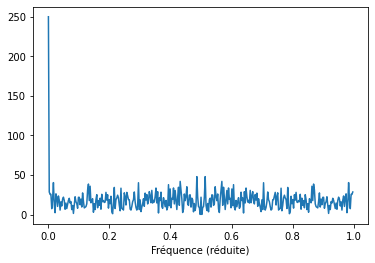

In [13]:
%matplotlib inline
plt.plot(f, np.abs(xf))
plt.xlabel("Fréquence (réduite)")

(0.0, 1.0, 0.0, 100.0)

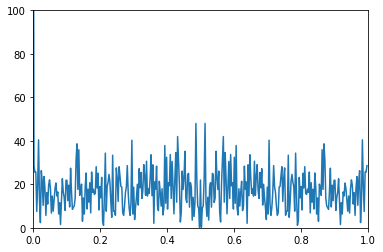

In [15]:
%matplotlib inline
plt.plot(f, np.abs(xf))
plt.axis([0, 1, 0, 100])

In [14]:
# trouver les max
from scipy.signal import find_peaks
# Cette fonction pour trouver les max, il faut utiliser les paramètres pour 
# trouver les "bons" max, sinon il y en a plus - Au pire, on peut lire à l'oeil sur le graphique
peaks = find_peaks(np.abs(xf), height=200, distance=30) # attention, la distance est en points pas en f
peaks[0] / M

array([0.03278689, 0.1420765 , 0.28688525, 0.42896175, 0.57103825,
       0.71311475, 0.8579235 , 0.96721311])

In [15]:
ff1 = peaks[0][0] / M
ff2 = peaks[0][1] / M
ff3 = peaks[0][2]  / M
ff4 = peaks[0][3]  / M


#ff1 = peaks[0][0] / M
#ff2 = peaks[0][1] / M
#ff3 = peaks[0][2]  / M
#ff4 = peaks[0][3]  / M
#ff5 = peaks[0][4]  / M
#ff6 = peaks[0][5]  / M
#ff7 = peaks[0][6]  / M

In [16]:
ff2

0.14207650273224043

In [17]:
from sklearn.linear_model import LinearRegression
import pandas as pd 

In [18]:
reg = LinearRegression()

In [19]:
t = np.arange(1547,1913)
x1c = cos(2*pi*ff1*t )
x1s = sin(2*pi*ff1*t )

x2c = cos(2*pi*ff2*t )
x2s = sin(2*pi*ff2*t )

x3c = cos(2*pi*ff3*t )
x3s = sin(2*pi*ff3*t )

x4c = cos(2*pi*ff4*t )
x4s = sin(2*pi*ff4*t )

#x5c = cos(2*pi*ff5*t )
#x5s = sin(2*pi*ff5*t )

#x6c = cos(2*pi*ff6*t )
#x6s = sin(2*pi*ff6*t )

#x7c = cos(2*pi*ff7*t )
#x7s = sin(2*pi*ff7*t )

X = pd.DataFrame(data = {"t":t, "x1c":x1c, "x1s":x1s, "x2c":x2c, "x2s":x2s, "x3c":x3c, "x3s":x3s, "x4c":x4c, "x4s": x4s,
                        })
X

,t,x1c,x1s,x2c,x2s,x3c,x3s,x4c,x4s
0,1547,-0.179281,-0.983798,0.262962,-0.964806,0.376728,-0.926324,-0.794658,-0.607058
1,1548,0.025748,-0.999668,0.916317,-0.400454,0.815028,0.579421,0.978856,0.204552
2,1549,0.229688,-0.973264,0.886680,0.462383,-0.751132,0.660152,-0.971257,0.238033
3,1550,0.423914,-0.905702,0.196143,0.980575,-0.469977,-0.882679,0.773351,-0.633978
4,1551,0.600214,-0.799839,-0.640593,0.767880,0.967028,-0.254671,-0.423914,0.905702
...,...,...,...,...,...,...,...,...,...
361,1908,-0.935717,-0.352752,0.870285,0.492548,-0.716152,0.697944,-0.967028,0.254671
362,1909,-0.843776,-0.536696,0.162366,0.986731,-0.514793,-0.857315,0.762354,-0.647161
363,1910,-0.716152,-0.697944,-0.666575,0.745438,0.952635,-0.304115,-0.408304,0.912846
364,1911,-0.558244,-0.829677,-0.998674,-0.051479,0.077175,0.997018,-0.025748,-0.999668


In [20]:
reg.fit(X,x)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
reg.coef_

array([  -0.68833494,   79.19065483,  117.38416859,  -75.121252  ,
       -580.51152822,   33.51772272,  181.23177787,   65.23195242,
         22.41554104])

In [22]:
xx = reg.predict(X)

In [23]:
x

1547    4005
1548    3952
1549    2712
1550    2344
1551    2400
        ... 
1908    2490
1909    2533
1910    2960
1911    3655
1912    4053
Name: sales, Length: 366, dtype: int64

In [24]:
df_xx = pd.DataFrame(xx)
df_xx = df_xx.set_index(x.index)
df_xx

,0
1547,3215.544289
1548,3273.997670
1549,2629.576212
1550,2227.328163
1551,2557.749183
...,...
1908,2355.403957
1909,1924.188178
1910,2225.069095
1911,2897.537220


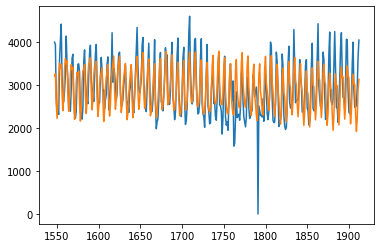

In [25]:
%matplotlib inline
plt.plot(x)
plt.plot(df_xx ) # + 0.2pour voir les 2 courbes
#plt.axis([0, 400, 15000, 40000])

(1730.0, 1755.0, 1900.0, 4000.0)

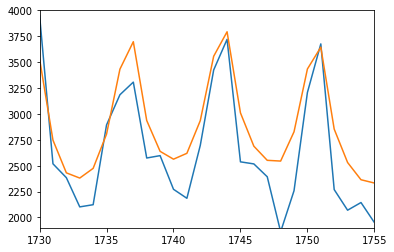

In [127]:
%matplotlib inline
plt.plot(x)
plt.plot(df_xx ) # + 0.2pour voir les 2 courbes
plt.axis([1730,1755 , 1900, 4000])

In [140]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1547,0.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,8.26
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1547,0.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,3.97
2,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,d_1547,1.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,2.97
3,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_1547,5.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,4.64
4,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_1547,0.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156946,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,3.98
11156947,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
11156948,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
11156949,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.00


In [144]:
df_xx

,0
1547,3215.544289
1548,3273.997670
1549,2629.576212
1550,2227.328163
1551,2557.749183
...,...
1908,2355.403957
1909,1924.188178
1910,2225.069095
1911,2897.537220


In [145]:
t = df.merge(df_xx, how='inner', on= df['id'].str.contain('FOODS'))

AttributeError: 'StringMethods' object has no attribute 'contain'